In [ ]:
import ira
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score

%alphalab light
%run ./CryptoCorrUtils.ipynb

# Data

Now we will use all data available from bitcoin.com, bitcoinity and google trends for causuality investigation.

Bitcoinity offers separate series for different exchanges (for volume, spread). Some exchanges were stopped and these series have gaps. 
To avoid that we will use averaged series. So we use Volume averaged from all venues etc.

From GT we fetch daily data for following queries: 'bitcoin', 'blockchain', 'btc' and 'crypto'

In [ ]:
# blockchain data: only 6 years to avoid free api limits
bcd = load_blockchain_data(timespan='6years')

# bitcoinity data
bas = load_bitcoinity_series('bidask_sum')
tpm = columns_add_pfx_sfx(load_bitcoinity_series('tradespm'), 'tpm')
tvol_all = columns_add_pfx_sfx(load_bitcoinity_series('volume'), 'volume')
tvol = tvol_all.mean(axis=1).rename('AverageVolume')
tspread_all = columns_add_pfx_sfx(load_bitcoinity_series('spread'), 'spread')
tspread = tspread_all.mean(axis=1).rename('AverageSpread')
trank_all = columns_add_pfx_sfx(load_bitcoinity_series('rank'), 'rank')
trank = trank_all[['rank_kraken', 'rank_bitstamp', 'rank_bitfinex', 'rank_others']].mean(axis=1).rename('AverageRank')

# google trends
gt = columns_add_pfx_sfx(pd.concat((load_google_trends(kw, '2012-09-01') for kw in ['bitcoin', 'blockchain', 'btc', 'crypto']), axis=1), 'G')

# Analysis

Let's look at google trends data. We see that series are correlated to BTC price (that's obvious).

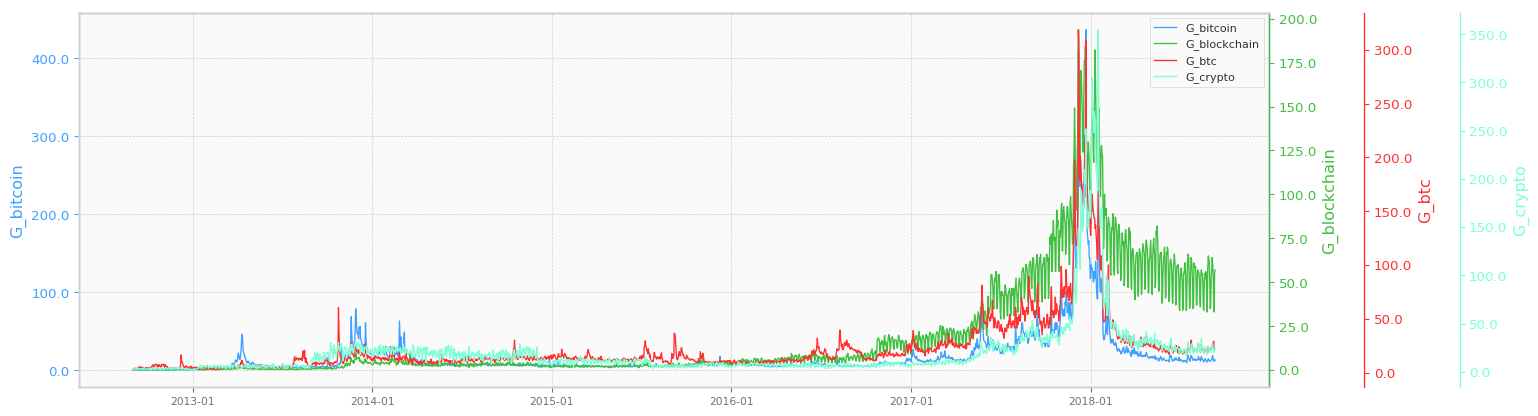

In [580]:
fig(16, 5)
multiplot(gt, x_format='%Y-%m')

Now we'll apply rolling slope measurement for all available series. Then we will calculate correlations between _lagged_ exogenous series slope and closing price slope using different lookbacks values for rolling window.

In [579]:
def rolling_slopes_frame(data, period, method='ols', scaling='binarize', no_lag='close', nlookback=1):
    if no_lag is None: no_lag = []
    if isinstance(no_lag, str): no_lag = [no_lag]
        
    new_keys = ['slope_%s' % (i) for i in data.columns]
    
    return pd.concat(
        (rolling_series_slope(data[i], period, method=method, scaling=scaling).shift(0 if i in no_lag else nlookback) for i in data.columns),
        axis=1, keys=new_keys
    )

def corr_statistics(d, periods, lookback=1):
    d_f = d.fillna(method='ffill').dropna()
    return pd.concat(
        (rolling_slopes_frame(d_f, p, method='ols', no_lag='close', nlookback=lookback).corr()['slope_close'][1:] for p in periods), 
        axis=1, keys=['RollWindow %d days' % p for p in periods])

In [78]:
extended_data = pd.concat((bcd, bas, tpm.mean(axis=1).rename('AverageTPM'), tvol, tspread, trank, gt), axis=1).fillna(method='ffill').dropna()
print('Dataset has %d features and %d days length starting from %s' % (extended_data.shape[1]-1, extended_data.shape[0], extended_data.index[0]))

Dataset has 19 features and 1800 days length starting from 2013-10-09 00:00:00


Statistics on whole dataset (actually from 2013 till now)

In [79]:
cstat1 = corr_statistics(extended_data, [3, 7, 14, 28, 64], lookback=1)

In [80]:
cstat1

,RollWindow 3 days,RollWindow 7 days,RollWindow 14 days,RollWindow 28 days,RollWindow 64 days
slope_volume,0.032836,0.051794,0.187877,0.392678,0.487831
slope_tr_per_day,0.033852,0.092471,0.224947,0.264801,0.210663
slope_uniq_addr,0.005563,0.128978,0.292576,0.325482,0.350017
slope_outvolume,0.027454,0.049522,0.080968,0.091030,0.052469
slope_e_tr_vol_usd,0.021705,0.148766,0.364981,0.512711,0.614509
slope_e_tr_vol,-0.019706,-0.021226,0.024197,0.068884,0.077152
slope_revenue,0.146234,0.502642,0.691150,0.810637,0.922662
slope_utxo_count,0.023246,-0.035771,-0.057923,-0.040672,0.054893
slope_asks,0.083240,0.318951,0.414148,0.505984,0.601001
slope_bids,0.035706,0.122535,0.249291,0.285860,0.306314


As we see correlation becomes to be significant for longer periods of rolling window for some series. Some series show enough strong correlations:
- 'slope_price' for instance - it's price slope on previous day and it express fact that market keeps moving same direction. 
- 'slope_revenue' - also strongest correlated series (more revenue generates more demand)
- 'slope_asks' has bigger correlation compared to 'slope_bids' probably because of fact that many people buying BTC by market orders
- volumes have expected correlations
- series from GT show strong correlation on longer rolling periods (increasing interest to crypto assets impact on price)

Some series do not demonstrate any predictive impact:
- Average Rank - this related to crypto exchahges ranking and obviously doesn't make any impact on prices
- AveragedSpread - it's bit technical info 

# Simple Predicting model 

It's clear that correlations are statistically significant and we could try to build simple linear regression trying to predict next day price slope as first step.
We will use 64 days rolling window (as most significant from correlation table above).

All slopes are normilized to range (-5, +5) with step 0.5

In [673]:
_f = rolling_slopes_frame(extended_data, 64, method='ols').dropna()
feat28, ty = _f.drop(columns=['slope_close']), _f['slope_close']

We split our dataset onto two parts: 2014 - mid of 2017 we will use as train set and mid 2017 - now for testing. 
So we will avoid taking in account rally on end of 17 - start 18'th.

In [674]:
tst_point = '2017-07-01'
m1 = OLS(ty[:tst_point], feat28[:tst_point])
r1 = m1.fit()
r1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:               OLS              Adj. R-squared:     0.972    
Dependent Variable:  slope_close      AIC:                1485.3476
Date:                2018-09-14 14:49 BIC:                1583.5506
No. Observations:    1298             Log-Likelihood:     -723.67  
Df Model:            19               F-statistic:        2360.    
Df Residuals:        1279             Prob (F-statistic): 0.00     
R-squared:           0.972            Scale:              0.18121  
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
slope_volume        -0.0125   0.0282 -0.4426 0.6581 -0.0679  0.0429
slope_tr_per_day     0.1412   0.0212  6.6758 0.0000  0.0997  0.1827
slope_uniq_addr     -0.1254   0.0245 -5.1118 0.0000 -0.1736 -0.0773
slope_outvolume     -0.0625   0.0173 -3.6229 0.0003 -0.0964 -0.0287
slope_e_tr_vol_usd  -0.0679   0.0396 -1.7168 0.0862 -0.1455  0.0097
slope_e_tr_vol       0.0322   0.0379  0.8480 0.3966 -0.0422  0.1065
slope_revenue        0.2470   0.0182 13.5829 0.0000  0.2114  0.2827
slope_utxo_count     0.0012   0.0051  0.2359 0.8135 -0.0089  0.0113
slope_asks          -0.1368   0.0138 -9.9149 0.0000 -0.1638 -0.1097
slope_bids          -0.0322   0.0094 -3.4230 0.0006 -0.0506 -0.0137
slope_price          0.8671   0.0152 57.1773 0.0000  0.8374  0.8969
slope_AverageTPM     0.0275   0.0157  1.7566 0.0792 -0.0032  0.0582
slope_AverageVolume  0.0452   0.0122  3.7022 0.0002  0.0213  0.0692
slope_AverageSpread -0.0555   0.0086 -6.4828 0.0000 -0.0723 -0.0387
slope_AverageRank   -0.0120   0.0131 -0.9171 0.3592 -0.0376  0.0136
slope_G_bitcoin     -0.0562   0.0184 -3.0519 0.0023 -0.0923 -0.0201
slope_G_blockchain  -0.0160   0.0187 -0.8582 0.3909 -0.0526  0.0206
slope_G_btc          0.0204   0.0122  1.6700 0.0952 -0.0036  0.0444
slope_G_crypto       0.1164   0.0161  7.2519 0.0000  0.0849  0.1479
-------------------------------------------------------------------
Omnibus:              127.856       Durbin-Watson:          0.529  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       182.722
Skew:                 -0.748        Prob(JB):               0.000  
Kurtosis:             4.068         Condition No.:          18     
===================================================================

"""

From table above we see that model shows good results on testing period $R^2$ is 0.97. It means that regression explains next day slope very confident.

Now we test how it's going on test period:

In [675]:
predicted_slope = r1.predict(feat28[tst_point:])
test_ty = ty[tst_point:]
r2_score(test_ty, predicted_slope)

0.9573371475689781

We see that $R^2$ score still good on testing interval. So we could try to discard features that doesn't have significant meaning. We will drop all predictors having p-value above 0.03 (like AverageRank, TPM etc) 

In [676]:
t_stat = r1.summary2().tables[1]['P>|t|']
best_predictors = t_stat[t_stat < 0.03].index.tolist()
print(best_predictors)

m2 = OLS(ty[:tst_point], feat28[:tst_point][best_predictors])
r2 = m2.fit()
predicted_slope_best = r2.predict(feat28[tst_point:][best_predictors])
r2.summary2()

['slope_tr_per_day', 'slope_uniq_addr', 'slope_outvolume', 'slope_revenue', 'slope_asks', 'slope_bids', 'slope_price', 'slope_AverageVolume', 'slope_AverageSpread', 'slope_G_bitcoin', 'slope_G_crypto']


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:                OLS              Adj. R-squared:     0.972    
Dependent Variable:   slope_close      AIC:                1481.2287
Date:                 2018-09-14 14:49 BIC:                1538.0830
No. Observations:     1298             Log-Likelihood:     -729.61  
Df Model:             11               F-statistic:        4063.    
Df Residuals:         1287             Prob (F-statistic): 0.00     
R-squared:            0.972            Scale:              0.18174  
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
slope_tr_per_day     0.1559   0.0202   7.7080 0.0000  0.1162  0.1956
slope_uniq_addr     -0.1392   0.0203  -6.8447 0.0000 -0.1791 -0.0993
slope_outvolume     -0.0815   0.0151  -5.3880 0.0000 -0.1111 -0.0518
slope_revenue        0.2392   0.0157  15.2039 0.0000  0.2083  0.2700
slope_asks          -0.1424   0.0119 -12.0078 0.0000 -0.1656 -0.1191
slope_bids          -0.0370   0.0085  -4.3690 0.0000 -0.0537 -0.0204
slope_price          0.8641   0.0117  73.9606 0.0000  0.8412  0.8871
slope_AverageVolume  0.0538   0.0095   5.6326 0.0000  0.0350  0.0725
slope_AverageSpread -0.0542   0.0079  -6.8789 0.0000 -0.0697 -0.0388
slope_G_bitcoin     -0.0633   0.0135  -4.6969 0.0000 -0.0898 -0.0369
slope_G_crypto       0.0981   0.0124   7.9425 0.0000  0.0739  0.1224
--------------------------------------------------------------------
Omnibus:               126.388       Durbin-Watson:          0.523  
Prob(Omnibus):         0.000         Jarque-Bera (JB):       182.127
Skew:                  -0.737        Prob(JB):               0.000  
Kurtosis:              4.093         Condition No.:          8      
====================================================================

"""

This procedure gave us reduced regression model that produces bit better results on testing period:

In [677]:
r2_score(test_ty, predicted_slope_best)

0.959745470915945

We can predict price slope by simple regression model based on selected exogenous series with good accuracy.

# Naive trading model

We can notice that our price slope is measurement for something very like to 'speed' of price changes. 

We could try to employ this fact for creating very primitive startegy:

If we predict that our 'price speed' remains almost the same tomorrow and it's higher then some threshold (momentum persists on the market) we buy.
And opposite situation for opening short position.

So we could express our naive strategy as following rules:

<font color='green'>Position Opening rules:</font>

$$Long: \alpha_{i+1}' \ge T \land \alpha_{i+1}' \approx \alpha_i \rightarrow L $$
$$Short: \alpha_{i+1}' \le -T \land \alpha_{i+1}' \approx \alpha_i \rightarrow S $$

where 

$\alpha_{i+1}'$ is predicted price slope for next day, 

$\alpha_i$ - today's price slope, 

$T$ - entry threshold (actually we enter position only when predicted slope is above (below) this threshold),

$L$ and $S$ - appropriate signals for opening Long or Short position

When we say $\alpha_{i+1}' \approx \alpha_{i}$ it means that $\mid \alpha_{i+1}' - \alpha_{i} \mid \lt \varepsilon$

As closing rule we could employ following:

<font color='red'>Position Closing rules:</font>
$$L \land \alpha_i - \alpha_{i+1}' \gt E \rightarrow \emptyset$$
$$S \land \alpha_{i+1}' - \alpha_i \gt E \rightarrow \emptyset$$

where

$E$ is exit threshold (if we have Long position and predicted slope tomorrow is below than today's more then E we close position)


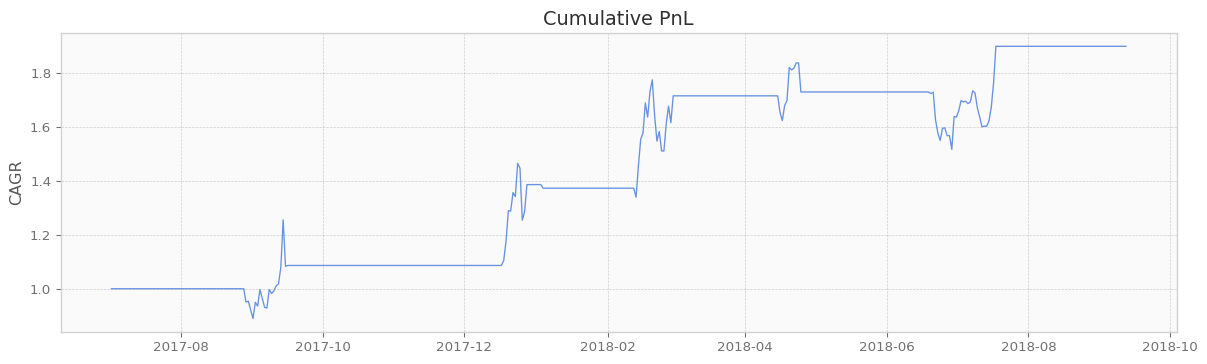

In [678]:
T, E, epsilon = 3.1, 0.5, 0.1

# put all together for best predictor
m = pd.concat((test_ty.shift(1), predicted_slope_best), axis=1, keys=['slope', 'pred'])

# apply entry rules
longs  = +1 * ((m.pred >= +T) & abs(m.pred - m.slope) < epsilon) 
shorts = -1 * ((m.pred <= -T) & abs(m.pred - m.slope) < epsilon)
sigs = longs + shorts

# apply exit rules
sigs[(sigs==+1) & (m.pred < m.slope - E)] = 0
sigs[(sigs==-1) & (m.pred > m.slope + E)] = 0

fig(15, 4)
plt.plot((p_ret * sigs.shift(1) + 1).cumprod())
plt.title('Cumulative PnL'); plt.ylabel('CAGR');

We see that in general we could generate profit using such simple momentum strategy.